In [151]:
%pip install deap

Note: you may need to restart the kernel to use updated packages.


Instalar a diblioteca DEAP

pip install deap

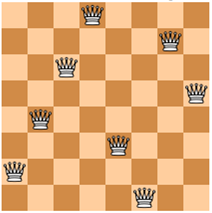

## Cromossomo

### Binário:
[001 011 101 111 010 000 110 100]

### Real:
[1 3 5 7 2 0 6 4]


In [152]:
%pip install matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [153]:
import numpy as np
import random
import time
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [154]:
#N = Número de rainhas
N = 128
#log_N = número de bits para representar cada rainha
log_N = int(np.log2(N))


#Funções extraídas do código original do livro
#https://github.com/aimacode/aima-python
def conflicted(state, row, col):
    """Colocar uma rainha em (linha, coluna) causaria algum conflito?"""
    return any(conflict(row, col, state[c], c)
               for c in range(col))

def conflict(row1, col1, row2, col2):
    """Colocar duas rainhas em (linha1, coluna1) e (linha2, coluna2) causaria conflito?"""
    return (row1 == row2 or  # same row
            col1 == col2 or  # same column
            row1 - col1 == row2 - col2 or  # same \ diagonal
            row1 + col1 == row2 + col2)  # same / diagonal

def goal_test(state):
    """Verificar se todas as colunas estão preenchidas sem conflitos."""
    if state[-1] == -1:
        return False
    return not any(conflicted(state, state[col], col)
                   for col in range(len(state)))

def h(node):
    """Retornar o número de rainhas em conflito para um determinado nó"""
    num_conflicts = 0
    for (r1, c1) in enumerate(node):
        for (r2, c2) in enumerate(node):
            if (r1, c1) != (r2, c2):
                num_conflicts += conflict(r1, c1, r2, c2)
    return num_conflicts

def nqueen_fitness(node):
    node_int = []
    for i in range(0, len(node), log_N):
        a = map(str, node[i:i+log_N])    
        node_int.append(int(''.join(a), 2))

    return h(node_int),
    
def plot_solution(solution, N):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, N))
    ax.set_ylim((0, N))

    # Adicionar quadriculado
    for i in range(N):
        for j in range(N):
            color = 'white' if (i + j) % 2 == 0 else 'black'
            ax.add_patch(patches.Rectangle((j, i), 1, 1, color=color))
    
    count = 0
    for queen in solution:
        ax.add_patch(patches.Circle((queen + 0.5, count + 0.5), radius=0.4, fill=True, color='red'))
        count += 1
    plt.show()

In [155]:
goal_test([2,4,6,8,3,1,7,4])

False

In [156]:
h([2,2,6,7,3,1,7,4])

8

In [157]:
#Cria ferramenta de geração de indivíduos
creator.create("Fitness", base.Fitness, weights=(-1.0, )) #Peso -1 por ser um problema de minimização

#Cada indíviduo é composto por um cromossomo que é uma lista de valores
creator.create("Individual", list, fitness=creator.Fitness)

In [158]:
#Toolbox é onde definiremos os operadores para a execução
toolbox = base.Toolbox()

#Função para criação do cromossomo
#x = 0|1
toolbox.register("attr_bool", random.randint, 0, 1) #np.random.randint(0,1)
#Função para Definir a criação do indivíduo. Será feita a repetição da função attr_bool por n vezes
#cromossomo = [x, x, x, x, ..., x]     len(cromossomo) = n
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N*log_N)
#Função para criar população. Repetição de indivíduos para formar uma lista
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [159]:
#função de avaliação
toolbox.register("evaluate", nqueen_fitness)
#função de cruzamento
toolbox.register("mate", tools.cxOnePoint)
#função de mutação
#indpb probabilidade de mutação em bit
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) # 0.5 é a probabilidade de mutação em cada bit
#função de seleção
"""
tournsize quantidade de individuos selecionados aleatoriamente
para participar do torneio para se tornar o pai da proxima geração
"""
toolbox.register("select", tools.selTournament, tournsize=3)

Operadores do framework DEAP

https://deap.readthedocs.io/en/master/api/tools.html

In [160]:
#Cria uma população de tamanho 1
"""
É comum em algoritmos genéticos, onde você começa com uma 
pequena população inicial e, em seguida, a população cresce 
e evolui ao longo das gerações.
"""
population = toolbox.population(n=1)

In [161]:
len(population[0])

896

In [162]:
nqueen_fitness(population[0])

(310,)

In [163]:
from tqdm import tqdm
execucoes = 5

for _ in range(execucoes):
    tempo_inicial = time.time()
    #Inicia população con n indivíduos
    population = toolbox.population(n=3000) # quanto maior a poupulação mais tempo demora para executar e mais chances de achar o melhor individuo

    #Número máximo de gerações
    NGEN=50 # para não stagnar, colocar um numero menor de gerações 

    #Avalia todos os indivíduos
    fits = toolbox.map(toolbox.evaluate, population)
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit
        
        
    avg = []
    tops = []
    worsts = []

    for gen in tqdm(range(NGEN)):
        #Faz seleção
        population = toolbox.select(population, k=len(population))
        #Faz o cruzamento e mutação
        #cxpb = probabilidade de cruzamento
        #mutpb = probabilidade de mutação
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.6, mutpb=0.1)
        
        #Reavalia a nova geração
        avg_h = 0
        fits = toolbox.map(toolbox.evaluate, offspring) 
        for fit, ind in zip(fits, offspring):
            avg_h += fit[0]
            ind.fitness.values = fit
            
        #nova população vão ser os filhos
        population[:] = offspring
            
        #pega melhor e pior indivíduos para montar o gráfico
        top = tools.selBest(population, k=1)
        worst = tools.selWorst(population, k=1)
        
        #calcula a média da população 
        avg_h = avg_h/len(population)
        #pega a quantidade de conflitos do melhor e pior individuo 
        top_h = nqueen_fitness(top[0])[0]
        worst_h = nqueen_fitness(worst[0])[0]

        #adiciona nas listas os dados obtidos da atual geração
        avg.append(avg_h)
        tops.append(top_h)
        worsts.append(worst_h)
        
        
        #Avalia critério de parada
        if(nqueen_fitness(top[0])[0] == 0): break
    tempo_final = time.time()
    node_int = []

    minutos = (tempo_final - tempo_inicial) // 60
    segundos = (tempo_final - tempo_inicial) % 60
    for i in range(0, len(top[0]), log_N):
        a = map(str, top[0][i:i+log_N])    
        node_int.append(int(''.join(a), 2))        
    print(f' [EXECUCAO {_}] \nMelhor individuo: \'{node_int}\'\n contem {nqueen_fitness(top[0])} conflitos\nTempo de execução: {minutos:.2f} min {segundos:.2f} seg')

100%|██████████| 50/50 [13:01<00:00, 15.63s/it]


 [EXECUCAO 0] 
Melhor individuo: '[51, 102, 43, 17, 24, 22, 69, 120, 58, 116, 42, 56, 82, 98, 25, 34, 6, 125, 41, 51, 126, 117, 49, 60, 64, 106, 118, 85, 46, 0, 31, 126, 36, 9, 38, 97, 117, 96, 60, 52, 112, 119, 15, 3, 104, 127, 14, 89, 113, 21, 109, 59, 116, 1, 69, 64, 81, 92, 58, 115, 47, 35, 0, 27, 23, 15, 11, 37, 62, 39, 6, 100, 105, 111, 55, 88, 25, 1, 114, 32, 66, 36, 103, 79, 109, 7, 89, 56, 111, 29, 70, 104, 121, 87, 78, 14, 93, 57, 90, 46, 83, 13, 80, 66, 86, 94, 26, 63, 47, 7, 12, 39, 45, 28, 10, 12, 40, 116, 83, 75, 97, 18, 51, 84, 55, 67, 53, 91]'
 contem (124,) conflitos
Tempo de execução: 13.00 min 17.80 seg


100%|██████████| 50/50 [12:57<00:00, 15.54s/it]


 [EXECUCAO 1] 
Melhor individuo: '[19, 61, 115, 86, 98, 55, 101, 93, 16, 91, 58, 80, 111, 25, 81, 118, 90, 72, 79, 103, 113, 92, 42, 23, 123, 5, 8, 43, 57, 97, 109, 34, 105, 10, 27, 114, 121, 62, 2, 57, 54, 74, 120, 69, 6, 3, 109, 12, 15, 94, 70, 95, 3, 115, 76, 111, 96, 53, 41, 20, 38, 104, 51, 109, 45, 102, 6, 14, 0, 50, 22, 16, 106, 124, 121, 126, 32, 119, 64, 110, 88, 107, 54, 0, 37, 94, 127, 24, 112, 46, 69, 126, 68, 34, 44, 112, 5, 15, 65, 41, 123, 67, 26, 32, 12, 29, 31, 117, 43, 116, 64, 82, 96, 87, 36, 83, 108, 65, 49, 52, 122, 4, 124, 61, 125, 33, 28, 48]'
 contem (110,) conflitos
Tempo de execução: 13.00 min 13.33 seg


100%|██████████| 50/50 [12:52<00:00, 15.45s/it]


 [EXECUCAO 2] 
Melhor individuo: '[10, 30, 126, 8, 18, 9, 81, 84, 111, 64, 119, 57, 76, 100, 68, 23, 4, 116, 92, 32, 79, 114, 80, 97, 2, 31, 21, 49, 17, 113, 80, 66, 52, 6, 104, 71, 39, 97, 69, 2, 121, 124, 23, 34, 116, 127, 48, 15, 99, 96, 46, 60, 14, 95, 47, 107, 109, 96, 1, 70, 35, 88, 7, 87, 0, 113, 8, 44, 22, 105, 53, 26, 43, 120, 48, 24, 97, 46, 25, 19, 60, 0, 40, 98, 102, 117, 78, 67, 49, 37, 91, 98, 20, 62, 54, 36, 107, 101, 59, 40, 125, 122, 114, 11, 67, 12, 35, 83, 50, 7, 89, 120, 118, 43, 17, 82, 72, 83, 115, 110, 63, 42, 74, 29, 81, 62, 85, 77]'
 contem (110,) conflitos
Tempo de execução: 13.00 min 8.36 seg


100%|██████████| 50/50 [12:56<00:00, 15.53s/it]


 [EXECUCAO 3] 
Melhor individuo: '[99, 33, 92, 62, 73, 55, 112, 104, 37, 63, 7, 44, 61, 24, 29, 11, 71, 96, 22, 113, 44, 119, 48, 12, 52, 1, 72, 48, 57, 59, 110, 92, 52, 101, 123, 112, 94, 28, 116, 32, 111, 103, 0, 5, 19, 93, 37, 123, 114, 67, 107, 121, 90, 68, 89, 71, 123, 99, 65, 106, 57, 42, 126, 4, 102, 121, 34, 119, 120, 43, 54, 58, 19, 9, 35, 84, 127, 97, 42, 82, 66, 95, 117, 22, 54, 19, 6, 124, 39, 109, 26, 31, 45, 13, 51, 10, 50, 122, 30, 93, 121, 47, 6, 81, 69, 64, 8, 75, 17, 3, 73, 36, 124, 20, 85, 82, 80, 115, 46, 101, 103, 21, 67, 18, 98, 110, 108, 79]'
 contem (126,) conflitos
Tempo de execução: 13.00 min 12.48 seg


100%|██████████| 50/50 [13:01<00:00, 15.62s/it]

 [EXECUCAO 4] 
Melhor individuo: '[29, 90, 61, 14, 100, 102, 83, 113, 45, 33, 73, 62, 31, 54, 72, 125, 83, 47, 43, 95, 2, 27, 105, 53, 23, 9, 48, 32, 127, 119, 123, 81, 84, 120, 38, 5, 64, 81, 7, 32, 38, 119, 59, 115, 109, 126, 51, 90, 14, 26, 42, 39, 25, 16, 48, 55, 103, 28, 93, 91, 116, 68, 22, 5, 114, 0, 75, 77, 40, 12, 96, 97, 22, 65, 4, 61, 17, 125, 37, 30, 0, 124, 31, 24, 107, 20, 112, 4, 108, 56, 102, 76, 46, 24, 66, 52, 0, 86, 117, 126, 122, 94, 104, 8, 50, 63, 87, 106, 74, 10, 18, 97, 109, 76, 66, 71, 111, 35, 6, 6, 99, 13, 11, 8, 49, 115, 58, 110]'
 contem (108,) conflitos
Tempo de execução: 13.00 min 17.50 seg


In [164]:
print(f'Melhor individuo contem : {nqueen_fitness(top[0])} conflitos')

Melhor individuo contem : (108,) conflitos


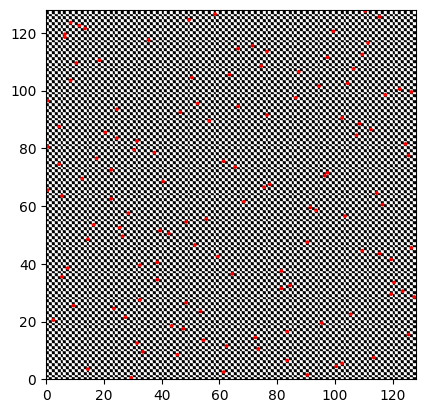

In [165]:
node_int = []
for i in range(0, len(top[0]), log_N):
    a = map(str, top[0][i:i+log_N])    
    node_int.append(int(''.join(a), 2))
    
plot_solution(node_int, N)

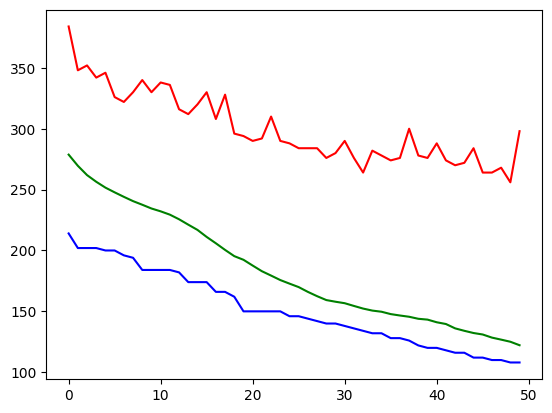

In [166]:
plt.plot(avg, c='g')
plt.plot(tops, c='b')
plt.plot(worsts, c='r')
plt.show()

In [167]:
print(node_int)

[29, 90, 61, 14, 100, 102, 83, 113, 45, 33, 73, 62, 31, 54, 72, 125, 83, 47, 43, 95, 2, 27, 105, 53, 23, 9, 48, 32, 127, 119, 123, 81, 84, 120, 38, 5, 64, 81, 7, 32, 38, 119, 59, 115, 109, 126, 51, 90, 14, 26, 42, 39, 25, 16, 48, 55, 103, 28, 93, 91, 116, 68, 22, 5, 114, 0, 75, 77, 40, 12, 96, 97, 22, 65, 4, 61, 17, 125, 37, 30, 0, 124, 31, 24, 107, 20, 112, 4, 108, 56, 102, 76, 46, 24, 66, 52, 0, 86, 117, 126, 122, 94, 104, 8, 50, 63, 87, 106, 74, 10, 18, 97, 109, 76, 66, 71, 111, 35, 6, 6, 99, 13, 11, 8, 49, 115, 58, 110]
